In [1]:
import collections 
import re 
from d2l import torch as d2l
import random
import torch

# RNN

## 文本预处理
1. 将文本作为字符串加载到内存中
2. 将字符拆分为词元
3. 建立词表， 将词元映射到数字索引
4. 将文本转为数字索引系列。
5. 将数字序列（corpus）制作迭代器

In [2]:
#1.读取数据 txt--> lines =[seq , seq, ,,,]
d2l.DATA_HUB['time_machine']=(d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():
    with open(d2l.download('time_machine'),'r') as f:
        lines= f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]
lines=read_time_machine()
print(f"文本行数:{len(lines)}")
print(lines[0])
print(lines[10])

文本行数:3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [3]:
# 2.词元化 lines--> tokens[['apple',banana],[pencial, ],,,,[][] ,]
def tokenize(lines,token='word'):
    if token == "word":
        return [line.split() for line in lines ]
    if token =="char":
        return [list(line) for line in lines]
    else:
        print("unknown token type")

tokens=tokenize(lines,token='word')
print(tokens[0])
print(tokens[10][1])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
and


词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。现在，让我们构建一个字
典，通常也叫做词表（vocabulary），用来将字符串类型的词元映射到从0开始的数字索引中。我们先将训练
集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的统计结果称之为语料（corpus）。然后根
据每个唯一词元的出现频率，为其分配一个数字索引。很少出现的词元通常被移除，这可以降低复杂性。另
外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“unk”。我们可以选择增加一个
列表，用于保存那些被保留的词元，例如：填充词元（“pad”）；序列开始词元（“bos”）；序列结束词元
（“eos”）。


In [4]:
# 
class Vocab:
    def __init__(self,tokens,reserved_tokens=None,min_freq=0):
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
            reserved_tokens=[]
        #按频率排序
        counter= count_corpus(tokens)
        self._token_freqs=sorted(counter.items(),key=lambda x:x[1],reverse=True)
        # 未知词元索引
        self.idx_to_tokens=['unk']+reserved_tokens
        self.token_to_idx={token:idx for token, idx in enumerate(self.idx_to_tokens)}
        for token , freq in self._token_freqs:
            if freq <min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_tokens.append(token)
                self.token_to_idx[token]=len(self.idx_to_tokens)-1
    
    def __len__(self):
        return len(self.idx_to_tokens)
    def __getitem__(self,tokens):   # 给出位置
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self,indices):   # 给出tokens
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_tokens[indices]
        return [self.to_tokens(idx) for idx in indices]
    @property
    def unk(self):
        return 0
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0],list):
        tokens=[token for lines in tokens for token in lines] # 双重for循环展开
    return collections.Counter(tokens) # 返回字典类型 的统计

In [5]:
vocab=Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])
print(vocab.to_tokens(1))
print(vocab['the'])

[(0, 'unk'), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
the
1


In [6]:
corpus = [vocab[token] for line in tokens for token in line]
print(corpus)
print(vocab.to_tokens(corpus))

[1, 19, 50, 40, 2183, 2184, 400, 2, 1, 19, 71, 16, 37, 11, 115, 42, 680, 6, 586, 4, 108, 7, 1420, 5, 2185, 587, 6, 126, 25, 330, 127, 439, 3, 2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1, 148, 588, 825, 3, 1, 244, 2187, 4, 1, 2188, 2189, 8, 1, 2190, 4, 589, 363, 1, 2191, 9, 826, 3, 288, 8, 75, 2192, 75, 1422, 274, 25, 2193, 2194, 3, 1423, 126, 230, 131, 2195, 6, 42, 186, 35, 3, 26, 7, 9, 2196, 116, 289, 1424, 78, 76, 2197, 2198, 827, 4, 1, 2199, 4, 2200, 3, 27, 132, 11, 6, 126, 8, 21, 114, 1425, 1, 1046, 17, 5, 1426, 1427, 14, 55, 186, 3, 2201, 2202, 25, 2203, 79, 21, 153, 681, 14, 55, 76, 11, 3, 25, 2204, 22, 85, 440, 13, 590, 2, 502, 28, 6, 2205, 31, 53, 154, 1047, 9, 91, 180, 2206, 682, 1, 828, 16, 364, 29, 1428, 22, 15, 2207, 38, 2208, 23, 5, 2209, 38, 33, 9, 230, 5, 275, 69, 6, 829, 126, 6, 830, 35, 46, 235, 54, 2210, 1429, 17, 164, 591, 2, 187, 33, 503, 6, 1430, 22, 6, 2211, 683, 276, 1431, 236, 16, 11, 22, 115, 197, 831, 14, 181, 14, 2, 504, 30, 22, 22, 151, 4, 313, 9, 5, 10

In [7]:
# 整合所有功能
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
# 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
# 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

## 数据采样
随机采样
在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。在迭代过程中，来自两个相邻的、随机
的、小批量中的子序列不一定在原始序列上相邻。

In [8]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    corpus=corpus[random.randint(0,num_steps-1):]
    num_subseqs=(len(corpus)-1) // num_steps   # 计算子序列数量
    initial_indices=list(range(0,num_steps*num_subseqs,num_steps)) # 每个子序列的开始索引
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]
    num_batches=num_subseqs // batch_size   # 计算batches数量

    for i in range(0,batch_size*num_batches,batch_size):
        initial_indices_per_batch=initial_indices[i:i+batch_size] 
        X=[data(j) for j in initial_indices_per_batch]
        Y=[data(j+1) for j in initial_indices_per_batch ] #因为 循环网络的训练 是 m->a a -> c  因此 +1是作为标签的特殊。
        yield torch.tensor(X), torch.tensor(Y)
        """
        b1:
        [seq1][i]
        [seq2]
        [seq3][i+batch_size]
        b2:
        [seq1][i+batch+size]
        [seq2]
        [seq3][i+batch_size+batch_size]
        """




In [9]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=3, num_steps=5):
    print('X: ', X, '\nY:', Y)



X:  tensor([[19, 20, 21, 22, 23],
        [ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[29, 30, 31, 32, 33],
        [14, 15, 16, 17, 18],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [15, 16, 17, 18, 19],
        [ 5,  6,  7,  8,  9]])


在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的小批量中的子序列在原始序列
上也是相邻的。这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区

In [10]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [11]:
class SeqDataLoader:
    def __init__(self,corpus,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn=seq_data_iter_random
        else:
            self.data_iter_fn=seq_data_iter_sequential
        self.corpus, self.vocab= load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps=batch_size,num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)
def load_data_time_machine(batch_size, num_steps, #@save
    use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
    batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab


## 实现循环神经网络

In [12]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [13]:


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

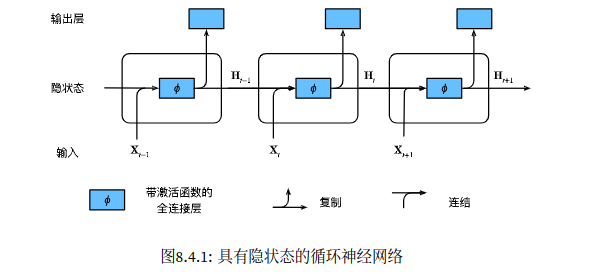

In [14]:
# one-hot 编码
"""
将tokens映射为对应为1 其他为0的向量。例[0,1,0..]
"""

'\n将tokens映射为对应为1 其他为0的向量。例[0,1,0..]\n'

In [15]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

我们可能遇到隐状态包含多个变量的情况，使用元组可以更容易些。(H, )

In [16]:
# 定义 rnn网络
def rnn(inputs, state, params):
# inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
# X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [17]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
        get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [18]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

RuntimeError: Class values must be smaller than num_classes.

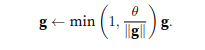

In [ ]:
# 梯度裁剪
def grad_clipping(net,theta):
    if isinstance(net,nn.modules):
        params=[p for p in net.parameters()]
    else:
        params=net.params
    norm=torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params :
            param.grad[:] *= theta/norm

In [ ]:
# 训练周期
def train_epoch_ch8(train_iter,use_random_iter,device,net,loss,updater):
    state,timer=None,d2l.Timer()
    metric=d2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Moudle) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
    y=Y.Y.reshape(-1)
    X,y=X.to(device),y.to(device)
    y_hat,state =net(X,state)
    l=loss(y_hat,y.long()).mean()
    if isinstance(updater,torch.optim.Optimizer):
        updater.zero_grad()
        l.backward()
        grad_clipping(net,1)
        updater.step()
    else:
        l.backward()
        grad_clipping(net,1)
        updater(batch_size=1)
    metric.add(1*y.numel(),y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
    
            

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
        use_random_iter=False):
        """训练模型（定义见第8章）"""
        loss = nn.CrossEntropyLoss()
        animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
        legend=['train'], xlim=[10, num_epochs])
        # 初始化
        if isinstance(net, nn.Module):
            updater = torch.optim.SGD(net.parameters(), lr)
        else:
            updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
            predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
        # 训练和预测
        for epoch in range(num_epochs):
            ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
            print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
            print(predict('time traveller'))
            print(predict('traveller'))

## 简洁实现

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
state = torch.zeros((1, batch_size, num_hiddens))

In [ ]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer,vocab_size,**kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn=rnn_layer
        self.vocab_size=vocab_size
        self.num_hiddens=self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    def forward(self,inputs,state):
        X=F.one_hot(inputs.T.long(),self.vocab_size)
        X=X.to(torch.float32)
        Y,state=self.rnn(X,state)
        output=nn.linear(Y.reshape((-1,Y.shape[-1])))
        return output,state
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens),
                device=device)
        else:
        # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device))

In [ ]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

AttributeError: module 'torch.nn' has no attribute 'linear'

1. 准备字典
2. 制作迭代器
3. 制作网络类 { 1. 制作网络2. 定义传递方法 3. 设置出状态  }
4. 定义优化器
5. 定义训练器。
5. 定义评价函数。

## 例子

In [19]:
import torch
import numpy as np

# 假设我们有 100 期数据，每期有 16 个号码
num_periods = 100  # 总期数
num_numbers = 16   # 每期 16 个开奖号码
time_steps = 5     # 用前 5 期预测下一期

# 生成一个假设的数据集
np.random.seed(42)
data = np.random.randint(1, 100, size=(num_periods, num_numbers))

# 构造 LSTM 输入数据
X, Y = [], []
for i in range(num_periods - time_steps):
    X.append(data[i:i+time_steps])   # 过去 5 期
    Y.append(data[i+time_steps])     # 预测下一期

X = np.array(X)  # 形状: (样本数, 5, 16)
Y = np.array(Y)  # 形状: (样本数, 16)

# 将数据转为 PyTorch 张量
X = torch.tensor(X, dtype=torch.float32)  # (样本数, 5, 16)
Y = torch.tensor(Y, dtype=torch.float32)  # (样本数, 16)

print("X shape:", X.shape)  # (95, 5, 16)
print("Y shape:", Y.shape)  # (95, 16)
# 数据划分：80% 训练集，20% 验证集
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")


X shape: torch.Size([95, 5, 16])
Y shape: torch.Size([95, 16])


In [ ]:
import torch.utils.data as data

# 使用 TensorDataset 和 DataLoader 来创建批量数据
train_data = data.TensorDataset(X_train, Y_train)
val_data = data.TensorDataset(X_val, Y_val)

batch_size = 16
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [ ]:
import torch.nn as nn

class LotteryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LotteryLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 输出层
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # LSTM 处理
        lstm_out, (hn, cn) = self.lstm(x)
        
        # 取最后一个时刻的输出
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 经过全连接层得到最终输出
        out = self.fc(lstm_out)
        return out

# 模型参数
input_size = 1  # 每个时间步的特征数（彩票每个数字）
hidden_size = 64  # LSTM 隐藏层大小
output_size = num_numbers  # 每期 16 个号码

# 初始化模型
model = LotteryLSTM(input_size, hidden_size, output_size)


In [ ]:
# 损失函数和优化器
criterion = nn.MSELoss()  # 如果是回归问题，使用 MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    for inputs, labels in train_loader:
        # inputs: (batch_size, 5, 16)
        # labels: (batch_size, 16)
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # 每个 epoch 输出损失
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# 训练结束
print("Training Finished!")


: 

In [ ]:
# 评估模型
model.eval()  # 设置模型为评估模式
val_loss = 0.0
with torch.no_grad():  # 在评估时不需要计算梯度
    for inputs, labels in val_loader:
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss/len(val_loader)}")


NameError: name 'val_loader' is not defined

In [ ]:
,,

torch.Size([3, 3])